In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits
from utils_shear_ana import catutil
import healpy as hp
import pymaster as nmt
import sacc
import sys
sys.path.insert(0, "../script")
from constants import *
import treecorr
%load_ext autoreload
%autoreload 2

# Calculate average multiplicative bias and shear response

In [2]:
data_z1 = []
i = 4
data_dir = os.environ.get("HSCY3_DATADIR", "/hildafs/datasets/shared_phy200017p/HSC_shape_catalog_Y3/catalog_obs_reGaus_public")
for fieldname in ["XMM", "VVDS", "HECTOMAP", "GAMA09H", "WIDE12H", "GAMA15H"]:
    file_name = os.path.join(data_dir, "%s.fits" % fieldname)
    data = pyfits.getdata(file_name)
    sel = (data["hsc_y3_zbin"] == i) & (data["b_mode_mask"])
    data_z1.append(data[sel])
data_z1 = np.hstack(data_z1)
wsum = np.sum(data_z1['i_hsmshaperegauss_derived_weight'])

In [3]:
# Multiplicative bias
mbias = np.sum(
    data_z1['i_hsmshaperegauss_derived_shear_bias_m']
    * data_z1['i_hsmshaperegauss_derived_weight']
) / wsum

# Regauss Shear response
response = 1 - np.sum(
    data_z1['i_hsmshaperegauss_derived_rms_e']**2.0
    * data_z1['i_hsmshaperegauss_derived_weight']
) / wsum

# Selection bias
msel, asel, msel_err, asel_err = catutil.get_sel_bias(
    data_z1['i_hsmshaperegauss_derived_weight'],
    data_z1['i_apertureflux_10_mag'],
    data_z1['i_hsmshaperegauss_resolution'],
)

# Transfor the shape catalog to shear catalog

In [4]:
# shear
g1, g2 = catutil.get_shear_regauss(data_z1, mbias, msel, asel)
# position
ra, dec = catutil.get_radec(data_z1)
# weight
weight = catutil.get_shape_weight_regauss(data_z1)
weight2 = np.ones_like(weight)
# ellipticity
e1, e2 = catutil.get_gal_ellip(data_z1)

In [5]:
nside = 128
npix = hp.nside2npix(nside)
all_indices = np.arange(npix)
pixels = hp.ang2pix(nside, ra, dec, lonlat=True)
no_gals_pix = np.setdiff1d(all_indices, pixels)
gals_per_pix = np.bincount(pixels)
Omega_pix = hp.nside2pixarea(nside, degrees=False)
fsky = 416 / 41253

Nbar = np.average(gals_per_pix[gals_per_pix != 0])

mask = np.zeros(npix, dtype=int)
g1_map = np.zeros(npix, dtype=float)
g2_map = np.zeros(npix, dtype=float)

mask[pixels] = 1
np.add.at(g1_map, pixels, g1)
np.add.at(g2_map, pixels, g2)

g1_map /= Nbar
g2_map /= Nbar

g1_map[no_gals_pix] = hp.UNSEEN
g2_map[no_gals_pix] = hp.UNSEEN

e1_weight = np.bincount(pixels, weights=e1**2 * weight2**2, minlength=npix)
e2_weight = np.bincount(pixels, weights=e2**2 * weight2**2, minlength=npix)
weight_map = np.bincount(pixels, weights=weight2, minlength=npix)
e1_weight[weight_map != 0] /= weight_map[weight_map != 0]
e2_weight[weight_map != 0] /= weight_map[weight_map != 0]

Nl = 0.5 * (np.mean(e1_weight[weight_map != 0]) + np.mean(e2_weight[weight_map != 0]))
Nl *= Omega_pix * fsky


In [6]:
nside = 128
npix = hp.nside2npix(nside)
pixels = hp.ang2pix(nside, ra, dec, lonlat=True)
gals_per_pix = np.bincount(pixels, minlength=npix)
Ngal = np.bincount(pixels, minlength=npix)
Nbar = np.average(gals_per_pix[gals_per_pix != 0])

g1_map = np.bincount(pixels, weights=g1, minlength=npix) / Nbar
g2_map = np.bincount(pixels, weights=g2, minlength=npix) / Nbar

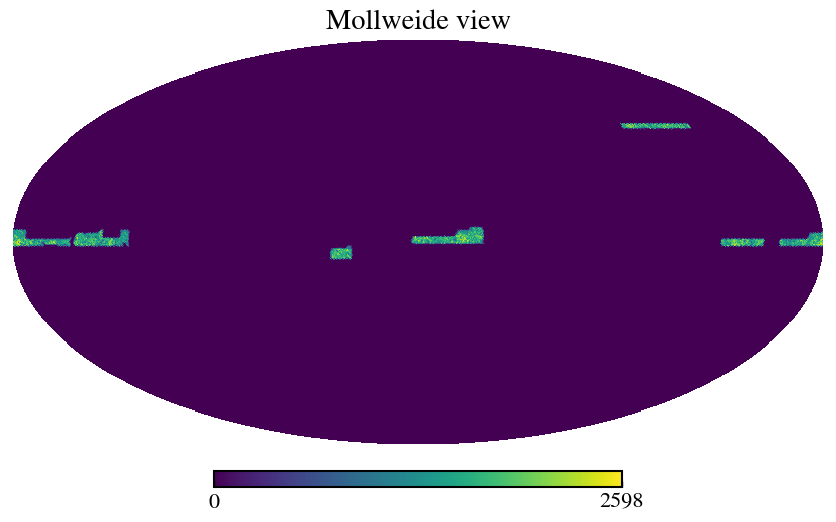

In [7]:
hp.mollview(Ngal, Nbar)

In [8]:
cls = hp.anafast([mask, g1_map, g2_map], pol=True, use_pixel_weights=True)

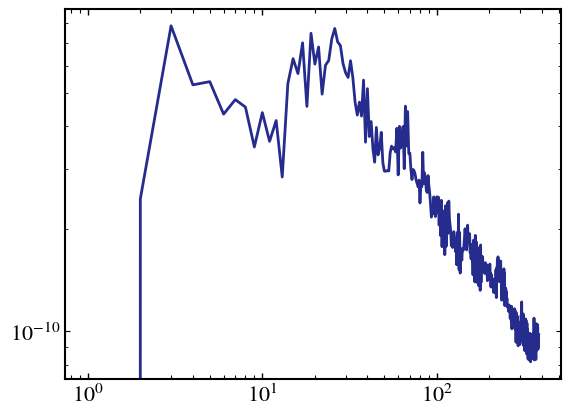

In [9]:
plt.loglog(cls[1])